# Exploration

**Goal**
> Changes in google results across time

## Roadmap

1. Load and merge data
2. Impute results count for a daily count
3. Visualize
    1. Line plot with plotly

### Load and merge data

In [3]:
import yaml
# ~--- SETTINGS ---
with open('../settings.yml') as file:
    settings = yaml.full_load(file)
    
RAW_DATA_DIR = settings['project']['raw_data_dir']
FINAL_DATA_DIR = settings['project']['final_data_dir']
FILENAME = settings['project']['export_filename']
# ~--------------

### LOAD RAW DATA

In [1]:
"""
~-- LOAD RAW DATA
Loads the queried data from the external data directory (data/0_raw)
"""

from glob import glob
import os
import pandas as pd
import logging

def load(raw_data_dir, filename):
    # merge all data from directory
    data_files = glob(f'{os.path.join(raw_data_dir, filename)}*')
    logging.info(
        f"Load data from raw data dir: {raw_data_dir}, Filename: {filename}")
    # specify column dtypes
    df_list = [pd.read_csv(file) for file in data_files]
    df = pd.concat(df_list).reset_index(drop=True)
    df = set_dtypes(df)
     
    assert_raw_df(df) # check dataframe against what we expect

    return df

def set_dtypes(df):
    """ Set dtypes for columns """
    # drop rows where a column names appear (happened while appending to csv)
    df = df.loc[df[df.columns[0]] != df.columns[0]]
    # convert numerics
    df = df.apply(pd.to_numeric, errors='ignore')
    # parse timestamps
    df.query_timestamp = df.query_timestamp.apply(pd.to_datetime)
    # reset index
    df.reset_index(inplace=True, drop=True)

    return df

def assert_raw_df(df):
    """Check that dataframe meets expecations for existing columns and dtypes"""
    # assert columns
    expected_columns = ['keyword', 'results_count', 'search_url', 'query_timestamp']
    assert_columns = list(set(df.columns).difference(set(expected_columns)))
    assert len(assert_columns) == 0,\
        f"Expected columns {expected_columns}.\nFound {assert_columns} instead."
    # assert at least 1 datetime column
    assert (df.dtypes == 'datetime64[ns]').any(), "Column type 'Datetime64[ns]' not found in dataframe "

### TRANSFORM

In [2]:
"""
~-- TRANSFORM
Prepares the raw data, making it ready for analysis. 
Stores dataset in data/2_final
"""

import pandas as pd 
import logging
from datetime import date

def impute_results_count(df):
    """ Impute timestamp to daily observations, interpolate with polynomial """
    
    # categorical columns to group on (keyword and search_url)
    groupby_columns = df.select_dtypes('object').columns.to_list()

    # assert expected grouping columns
    expect_object_columns = ['search_url', 'keyword']
    assert set(groupby_columns) == set(expect_object_columns), \
        f"Columns {groupby_columns} not in {expect_object_columns} "

    kw_list, url_list = df.keyword.unique(), df.search_url.unique()
    df_list = []
    for kw, url in dict(zip(kw_list, url_list)).items():
        df_temp = df.set_index('query_timestamp')\
                .query(f"keyword=='{kw}'")\
                .resample('D').mean()\
                .results_count.interpolate(method='polynomial', order=3)\
                .reset_index() 
        df_temp['keyword'],df_temp['search_url']  = kw, url
        df_list.append(df_temp)
        
    df = pd.concat(df_list)
    
    return df

def feature_engineering(df):
    """Add statistics to raw data to analyze changes across time"""

    # day-to-day change  
    df['result_count_absolute_change'] = df.groupby('keyword').results_count.diff().reset_index(drop=True) # day-to-day absolute change
    df['result_count_relative_change'] = (df.result_count_absolute_change/df.results_count*100) # day-to-day relative change 

    # overall days keyword already tracked
    df['start_date'], df['end_date'] = df.groupby('keyword').query_timestamp.transform('min'), df.groupby('keyword').query_timestamp.transform('max')
    df['days_tracked'] = (df['end_date']-df['start_date']).dt.days
    
    return df

def subset_last_x_days(df, last_x_days=30):
    """ """
    # date_lxdays: exact date x days ago
    df['date_lxdays'] = df.groupby('keyword').query_timestamp.transform('max') - pd.Timedelta(days=last_x_days) 
    # for keywords added <30 days ago: replace with start_date
    df['date_lxdays'] = df.apply(lambda x: x.start_date if x.date_lxdays < x.start_date else x.date_lxdays, axis=1)
    
    # -- subset df to focus on overall change from start to end date 
    # select l30days per keyword (groupby)
    df = df.loc[(df.query_timestamp == df.date_lxdays) | (df.query_timestamp == df.end_date)].set_index('keyword') 
    df['lxdays_absolute_change'] = df.groupby('keyword').results_count.diff()

    # subset df to show overall changes from start_date (=when entered into list) to end_date (=mostly today)
    df_overall_change = df.dropna().reset_index()
    
    df_overall_change['results_count_xdaysago'] = df.loc[df.query_timestamp == df.date_lxdays].results_count.reset_index(drop=True)
    df_overall_change['lxdays_relative_change'] = ((df_overall_change.results_count / df_overall_change.results_count_xdaysago)-1)*100
    
    return df_overall_change

### TESTING

In [3]:
logging.basicConfig(level=logging.INFO)

df = (load(raw_data_dir='../data/0_raw', filename='google_results_count')
      .pipe(impute_results_count)
     .pipe(feature_engineering))



# TODO: visualization of circle size at start date -arrow->  size at end date

INFO:root:Load data from raw data dir: ../data/0_raw, Filename: google_results_count


### Plot

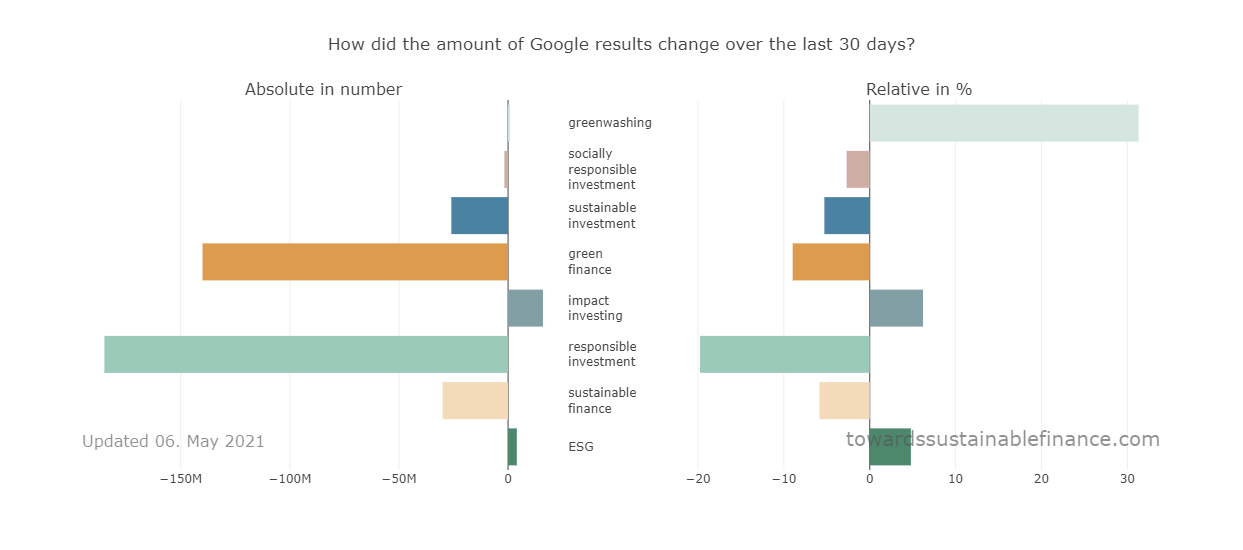

In [30]:
# -- layout template
import plotly.io as pio
import plotly.graph_objects as go
from datetime import datetime

tsf_colorscale = ["#4d886d", "#f3dab9", "#9bcab8", "#829fa5", "#dc9b4d", "#4a82a1", "#cfaea5", '#D5E6E0']
updated_on = datetime.now().strftime("%d. %B %Y")

# naming a layout theme for future reference
pio.templates["tsf"] = go.layout.Template(
    layout_colorway=tsf_colorscale, 
    layout_hovermode= 'closest', 
    # layout_plot_bgcolor='#D5E6E0'
    # dark font color: #545454
    layout_font_family='Verdana',
    layout_annotations=[
        dict(
            name="watermark",
            text=f"towardssustainablefinance.com",
            textangle=0,
            opacity=0.65,
            font=dict(color="#545454", size=20),
            xref="paper",
            yref="paper",
            x=1,
            y=0.05,
            showarrow=False,
        ), 
        dict(
            name="watermark2",
            text=f"Updated {updated_on}",
            textangle=0,
            opacity=0.65,
            font=dict(color="#545454", size=16),
            xref="paper",
            yref="paper",
            x=0,
            y=0.05,
            showarrow=False,
        )
    ]
)
pio.templates.default = 'tsf'

from plotly.subplots import make_subplots
import plotly.express as px
import chart_studio.plotly as py

# -- plot data
last_x_days = 30
df_lxdays = subset_last_x_days(df, last_x_days=last_x_days)
x_axis_labels = [s.replace(' ', '<br>') for s in df.keyword.unique()]

# fig = px.line(df, x="query_timestamp", y="results_count", color="keyword", 
#               title='Absolute Google results count over time', 
#              labels={
#                      "query_timestamp": "Date",
#                      "results_count": "Number of Google results",
#                      "keyword": ""
#                  },)
# # update legend
# fig.update_layout(legend=dict(
#     orientation="h",
#     yanchor="top",
#     y=1.1,
#     xanchor="right", 
#     x=0.9
# ))
# fig.show()

# # -------------
# fig = px.line(df, x="query_timestamp", y="result_count_relative_change", color="keyword", 
#              title='Relative change of Google results over time', 
#             labels={
#                      "query_timestamp": "Date",
#                      "result_count_relative_change": "Relative change of Google results [%]",
#                      "keyword": ""
#                  },)
# # update legend
# fig.update_layout(legend=dict(
#     orientation="h",
#     yanchor="top",
#     y=1.1,
#     xanchor="right", 
#     x=.98
# ))
# fig.show()

# ------------
plot_title = f"How did the amount of Google results change over the last {last_x_days} days?"
absolute_plot_title = 'Absolute in number'
relative_plot_title = 'Relative in %'
fig = make_subplots(rows=1, cols=2, 
                    shared_yaxes=True,
                    shared_xaxes=False,
                    subplot_titles=[absolute_plot_title, relative_plot_title])
fig.add_trace(
    go.Bar(
            x=df_lxdays.lxdays_absolute_change,
            y=x_axis_labels,
            orientation='h'
    ), 
    row=1, col=1
)
fig.update_yaxes(ticklabelposition='outside', side='right')
# fig.update_xaxes(title_text='hello', row=1, col=1)

fig.add_trace(
    go.Bar(
            x=df_lxdays.lxdays_relative_change,
            y=x_axis_labels,
            orientation='h'
    ), 
    row=1, col=2
)
# fig.update_xaxes(title_text='hello2', row=1, col=2)

fig.update_traces(marker=dict(color=tsf_colorscale), 
                showlegend=False)
fig.update_layout(title_text=plot_title,
                width=1000,
                height=550)

fig.show()

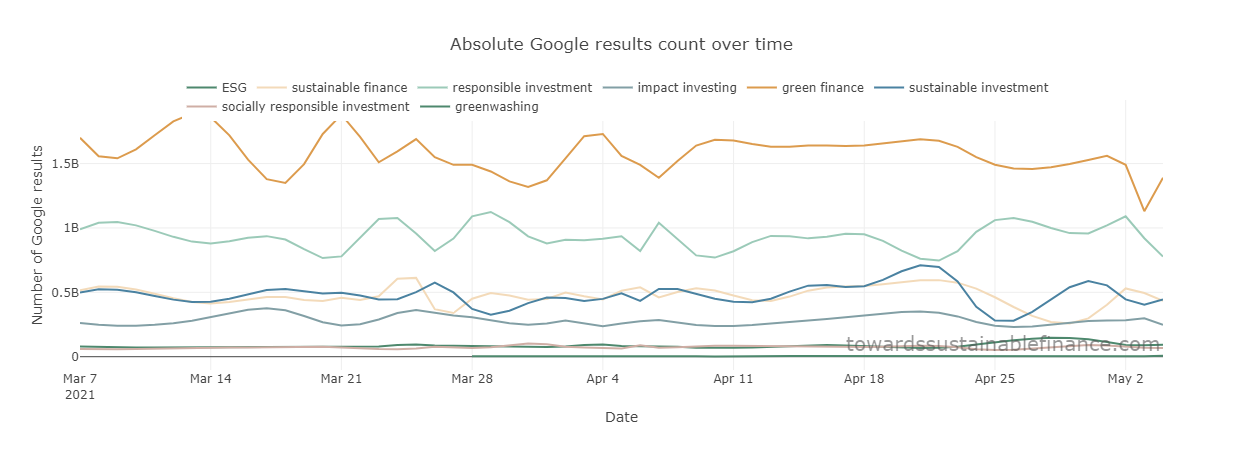

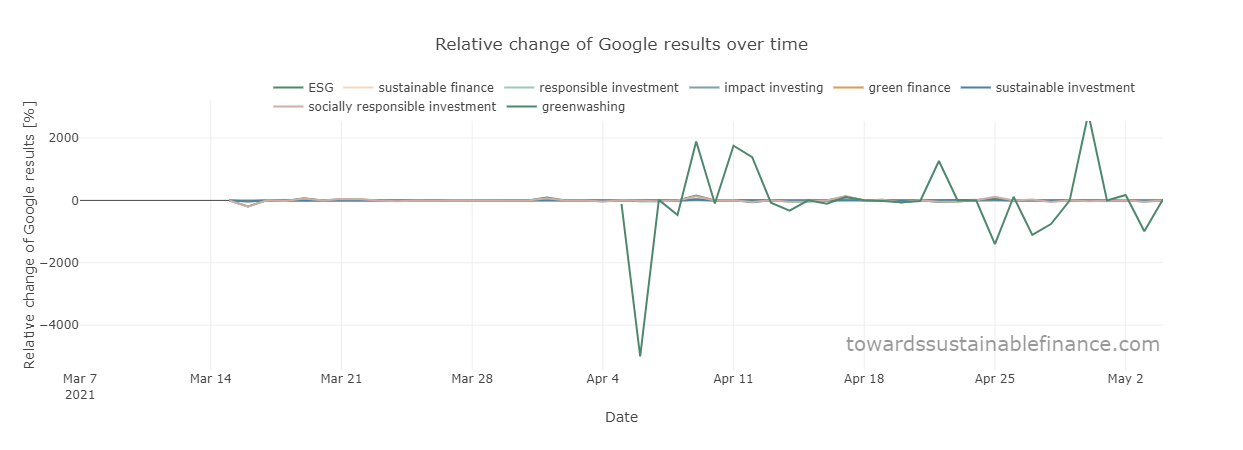

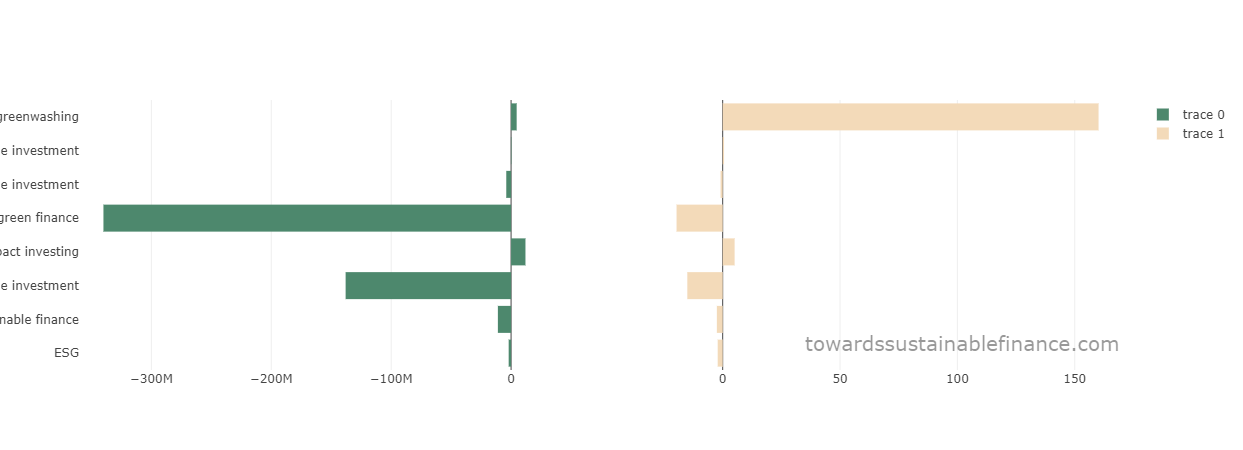

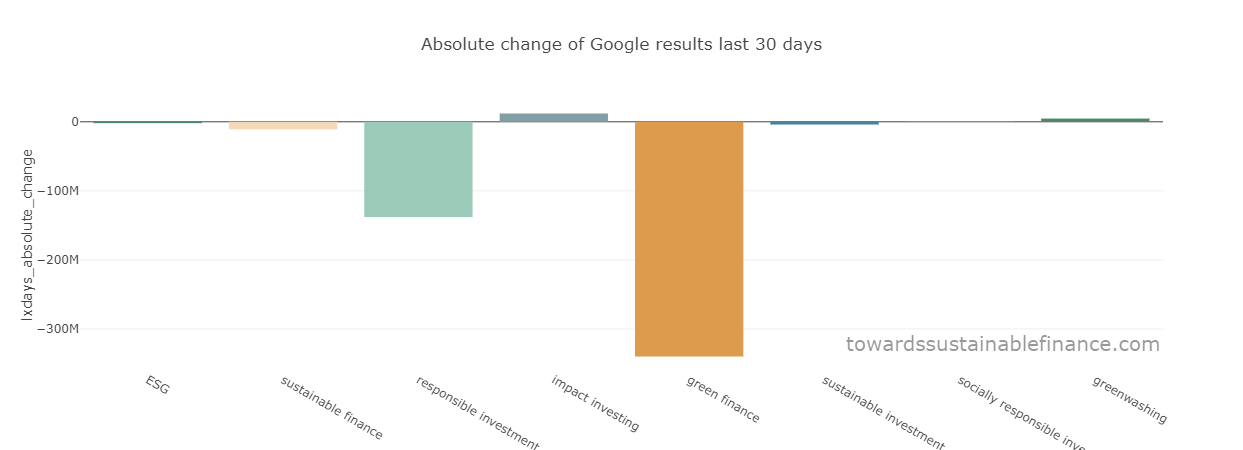

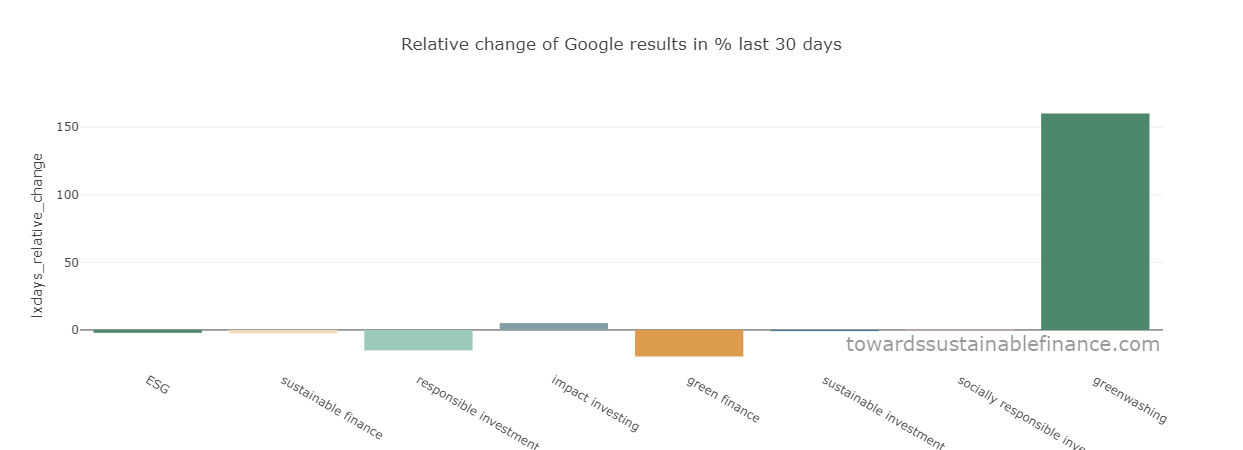

In [105]:
fig_abs_overall_change = px.bar(df_lxdays, x="keyword", y="lxdays_absolute_change", color="keyword", 
             title=f'Absolute change of Google results last {last_x_days} days', 
            labels={
                     "overall_absolute_change": "+/- of Google results",
                     "keyword": ""
                 },)
fig_abs_overall_change.update_layout(showlegend=False)
fig_abs_overall_change.show()

fig_rel_overall_change = px.bar(df_lxdays, x="keyword", y="lxdays_relative_change", color="keyword", 
             title=f'Relative change of Google results in % last {last_x_days} days', 
            labels={
                     "overall_relative_change": "% change of Google results",
                     "keyword": ""
                 },)
fig_rel_overall_change.update_layout(showlegend=False)
fig_rel_overall_change.show()

#### Deploy

In [71]:
py.plot(fig_abs_overall_change, filename=FILENAME+"_change_overall_absolute", auto_open=True)

py.plot(fig_rel_overall_change, filename=FILENAME+"_change_overall_relative", auto_open=True)

'https://plotly.com/~philippschmalen/97/'